In [1]:
import numpy as np
import pandas as pd
import os
import opendatasets as od
from tabulate import tabulate
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix




In [2]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data'
# Using opendatasets let's download the data sets
od.download(dataset)



Skipping, found downloaded files in ".\sms-spam-collection-dataset" (use force=True to force download)


In [3]:
for dirname, _, filenames in os.walk('./sms-spam-collection-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./sms-spam-collection-dataset\spam.csv


In [4]:
file_path = './sms-spam-collection-dataset/spam.csv'

In [5]:
df = pd.read_csv(file_path, encoding='latin-1')
print(tabulate(df.head(), headers='keys', tablefmt='psql'))


+----+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+--------------+--------------+
|    | v1   | v2                                                                                                                                                          |   Unnamed: 2 |   Unnamed: 3 |   Unnamed: 4 |
|----+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+--------------+--------------|
|  0 | ham  | Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                             |          nan |          nan |          nan |
|  1 | ham  | Ok lar... Joking wif u oni...                                                                                         

## Exploratory Data Analysis (EDA)


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [7]:
df.shape

(5572, 5)

In [8]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [9]:
df=df.drop(["Unnamed: 2", "Unnamed: 3","Unnamed: 4"], axis=1)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | v1   | v2                                                                                                                                                          |
|----+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | ham  | Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                             |
|  1 | ham  | Ok lar... Joking wif u oni...                                                                                                                               |
|  2 | spam | Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&

In [10]:
# change the name of the columns
df.columns = ['label','text']

In [11]:
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [12]:
# missing values
df.isna().sum() 

label    0
text     0
dtype: int64

In [13]:
df.label.value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [14]:
print("Out of {} rowes, {} are spam, {} are ham.".format(len(df),
                                                       len(df[df["label"] =="spam"]),
                                                        len(df[df["label"] =="ham"])))

Out of 5572 rowes, 747 are spam, 4825 are ham.


In [15]:
# check for duplicates
df.duplicated().sum()

403

In [16]:
# drop duplicates
df = df.drop_duplicates(keep="first")
df.duplicated().sum()


0

In [17]:
df.shape

(5169, 2)

([<matplotlib.patches.Wedge at 0x170c3d1c8f0>,
 [Text(-0.42519443516002475, -1.0144997251399075, 'ham'),
  Text(0.4638483711007677, 1.1067270163085225, 'spam')],
 [Text(-0.23192423736001347, -0.5533634864399495, '87.4%'),
  Text(0.2705782164754478, 0.6455907595133047, '12.6%')])

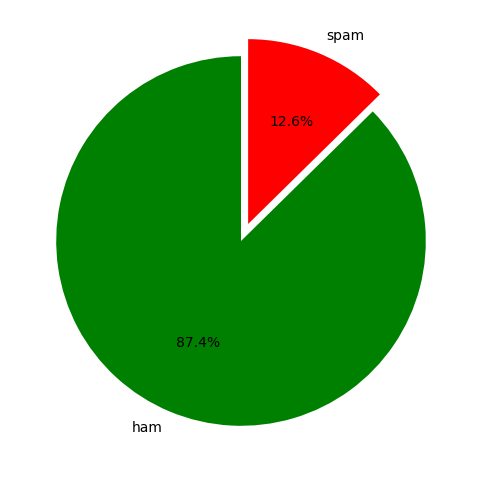

In [18]:
# label distribution using matplotlib
plt.figure(figsize=(8, 6))
plt.pie(df['label'].value_counts(), labels=['ham', 'spam'],colors="green", autopct='%1.1f%%', startangle=90, explode=(0, 0.1))

In [19]:
# add a new column, which indicates the length of each text
df["text_length"] = df["text"].apply(len) 
df.head()


,label,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


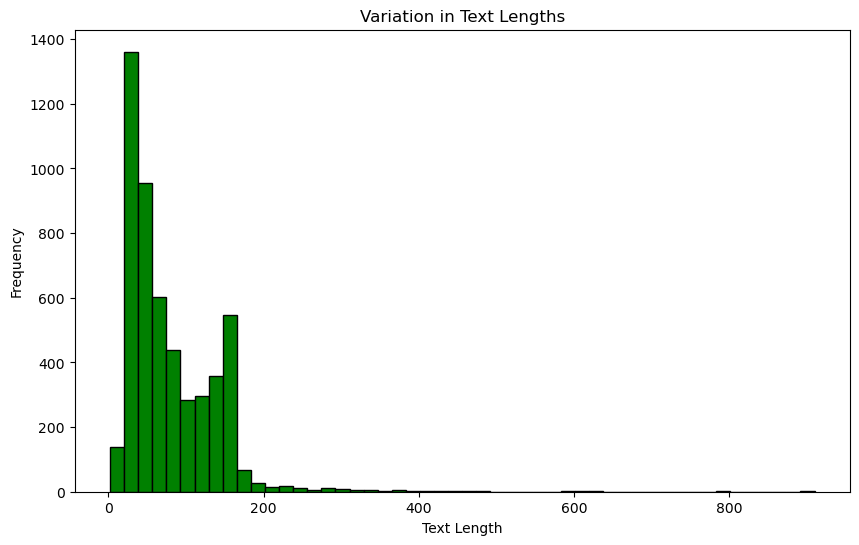

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, color='green', edgecolor='black')
plt.title('Variation in Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Spam Length Distribution')

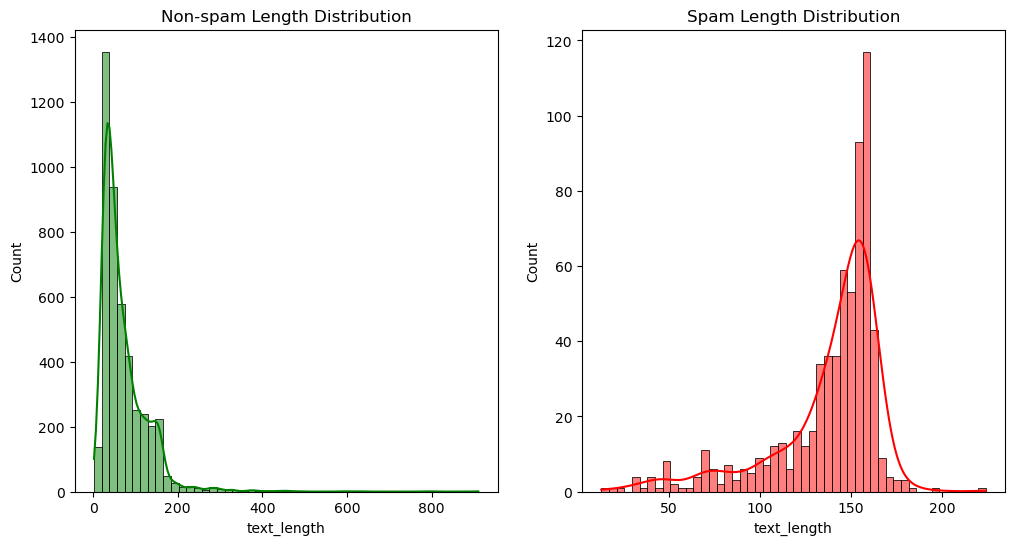

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['label']=='ham']['text_length'], bins=50, kde=True, color='green')
plt.title('Non-spam Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df[df['label']=='spam']['text_length'], bins=50, kde=True, color='red')
plt.title('Spam Length Distribution')


# Text Preprocessing



In [22]:
# Punctuation
def remove_punct(text):
   text_no_punc = ''.join([char for char in text if char not in string.punctuation])
   return text_no_punc
df['cleaned_text'] = df['text'].apply( lambda x: remove_punct(x))






In [23]:
# Tokenization
def tokenize_text(text):                           
    tokens = word_tokenize(text.lower())
    return tokens



In [24]:
df['tokenized_text'] = df['cleaned_text'].apply(lambda x: tokenize_text(x))

In [25]:
# Define stopwords using NLTK
stop_words = nltk.corpus.stopwords.words('English')
def remove_stopwords (token_list):
    text = [word for word in token_list if word not in stop_words]
    return text

In [26]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [27]:
 # Stemming
ps = nltk.PorterStemmer()      


In [28]:
def stemming(text_1):
    text = [ps.stem(word) for word in text_1]
    return text

In [29]:
# Lemmatization
wn = nltk.WordNetLemmatizer()


In [30]:
def lemmatising(text_2):
    text = [wn.lemmatize(word) for word in text_2]
    return text 

In [31]:

df['tokenized_text'] = df['cleaned_text'].apply(lambda x: tokenize_text(x))
df['nonstop_tok_text'] = df['tokenized_text'].apply(lambda x: remove_stopwords(x))
df['text_stemmed'] = df['nonstop_tok_text'].apply(lambda x: stemming(x))
df['lemmatised_text'] = df['text_stemmed'].apply(lambda x:lemmatising(x))

df.head()

,label,text,text_length,cleaned_text,tokenized_text,nonstop_tok_text,text_stemmed,lemmatised_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,49,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...","[nah, dont, think, goe, usf, live, around, tho..."


In [32]:
df['lemmatised_text'] = df['lemmatised_text'].apply(lambda x: ' '.join(x))

In [33]:
print(df['lemmatised_text'].head())

0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri 2 wkli comp win fa cup final tkt 21...
3                  u dun say earli hor u c alreadi say
4            nah dont think goe usf live around though
Name: lemmatised_text, dtype: object


In [34]:
# label encoding
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text,text_length,cleaned_text,tokenized_text,nonstop_tok_text,text_stemmed,lemmatised_text
0,0,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...",nah dont think goe usf live around though


## Choose and Implement Validation Method

In [35]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['lemmatised_text'])
y = df['label']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [38]:
models = {'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100, max_depth=100)
}

In [39]:
param_grid = {
    "LogisticRegression": {"C":[0.1,1, 10]},
    "DecisionTreeClassifier": {"max_depth": [None, 10,20,30]},
    "RandomForestClassifier": {"n_estimators":[100,200,300], "max_depth":[None, 10, 20, 30]}
}

In [40]:
best_models= {}

In [41]:
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")

Tuning hyperparameters for LogisticRegression...
Tuning hyperparameters for DecisionTreeClassifier...
Tuning hyperparameters for RandomForestClassifier...


In [42]:
 # Perform grid search
grid_search = GridSearchCV(model,param_grid[model_name],cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=100),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [43]:
 # Get the best model
best_model = grid_search.best_estimator_
best_models[model_name]= best_model

In [44]:
 # Cross-validation scores for the best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    
print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
print(f"Cross-validation accuracy scores for best {model_name}: {cv_scores}")
print(f"Mean cross-validation accuracy for best {model_name}: {cv_scores.mean()}\n")

Best hyperparameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 300}
Cross-validation accuracy scores for best RandomForestClassifier: [0.95974235 0.95967742 0.97258065 0.96935484 0.95483871]
Mean cross-validation accuracy for best RandomForestClassifier: 0.9632387927899849



# Calculate Training, Validation, and Test Metrics implementing Quality Metrics

In [45]:

for model_name, model in best_models.items():
    print(f'Evaluating{model_name}')
    model.fit(X_train,y_train)

EvaluatingRandomForestClassifier


In [46]:
# Training metrics
train_predictions = model.predict(X_train)
train_metrics = {
    'accuracy': accuracy_score(y_train, train_predictions),
    'precision': precision_score(y_train, train_predictions),
    'recall': recall_score(y_train, train_predictions),
    'f1-score': f1_score(y_train, train_predictions)
    }
print(f"Training Metrics for {model_name}:")
print(train_metrics)

Training Metrics for RandomForestClassifier:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}


In [47]:
 # Validation metrics
val_predictions = model.predict(X_val)
val_metrics = {
        'accuracy': accuracy_score(y_val, val_predictions),
        'precision': precision_score(y_val, val_predictions),
        'recall': recall_score(y_val, val_predictions),
        'f1-score': f1_score(y_val, val_predictions)
    }
print(f"Validation Metrics for {model_name}:")
print(val_metrics)

Validation Metrics for RandomForestClassifier:
{'accuracy': 0.9690522243713733, 'precision': 1.0, 'recall': 0.7217391304347827, 'f1-score': 0.8383838383838383}


In [48]:
test_predictions = model.predict(X_test)

In [49]:
accuracy = accuracy_score(y_test,test_predictions)
precision = precision_score(y_test,test_predictions, average="weighted")
recall = recall_score(y_test, test_predictions, average="weighted")
f1 = f1_score(y_test, test_predictions, average="weighted")
confusion_matrix = confusion_matrix(y_test, test_predictions)


In [50]:
print(f"classification report for {model_name}: ")
print(f"classification report for {test_predictions}: ")
print(f"accuracy for {model_name}:{accuracy}")
print(f"precision for {model_name}:{precision}")
print(f"recall for {model_name}:{recall}")
print(f"f1 for {model_name}:{f1}")
print(f"Confusion Matrix for {model_name}:\n{confusion_matrix}")

classification report for RandomForestClassifier: 
classification report for [0 0 0 ... 1 0 0]: 
accuracy for RandomForestClassifier:0.9680851063829787
precision for RandomForestClassifier:0.9692273965015923
recall for RandomForestClassifier:0.9680851063829787
f1 for RandomForestClassifier:0.9663268719289526
Confusion Matrix for RandomForestClassifier:
[[889   0]
 [ 33 112]]


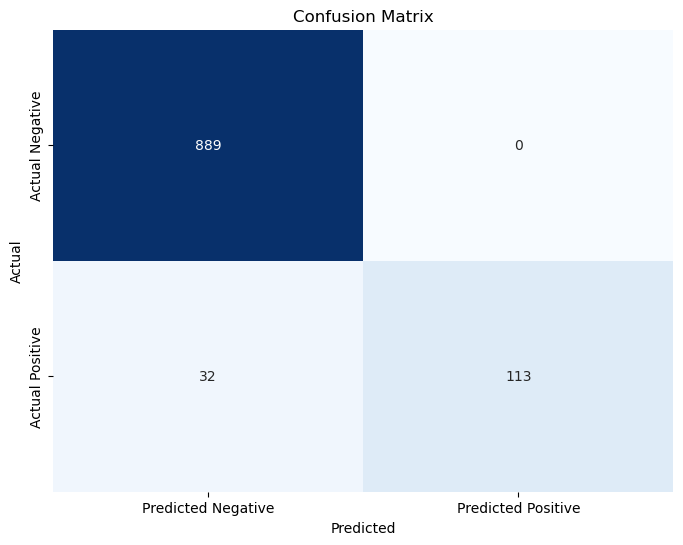

In [51]:
confusion_matrix = np.array([[889, 0],
                             [32, 113]])
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Test new data

In [52]:

best_model = best_models['RandomForestClassifier']

new_data = ["Dear user, You have won a $1,000 gift card! Click the link below to claim your prize: http://fakeurl.com. Act now before the offer expires!"]
new_data_transformed = tfidf.transform(new_data)
pred = best_model.predict(new_data_transformed)[0]

if pred == 0:
    print('This is a ham message')
else:
    print('This is a spam message')


This is a spam message


In [53]:
new_data = ['Hi, Ryan. Can we meet tomorrow at 8 pm?']
new_data_transformed = tfidf.transform(new_data)
pred = best_model.predict(new_data_transformed)[0]

if pred == 0:
    print('This is a ham message')
else:
    print('This is a spam message')


This is a ham message


In this project, I developed a machine learning model to classify SMS messages as spam or not. I started by downloading the dataset from Kaggle, then cleaned and preprocessed the text by removing punctuation, tokenizing, and lemmatizing. I tried various models including Logistic Regression, Decision Tree, and Random Forest, using GridSearchCV to find the best hyperparameters. The Random Forest model performed the best with high accuracy. Finally, I tested the model on new messages, demonstrating its ability to effectively distinguish between spam and non-spam messages. It was a great hands-on experience in NLP and machine learning.